# Frequency-dependent complex absorber

## Without an totorber the solution is periodic

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy

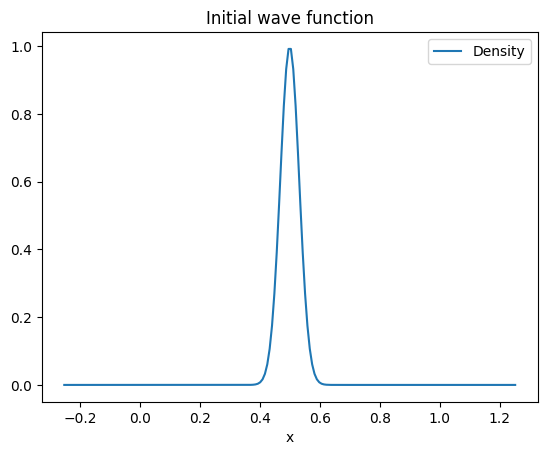

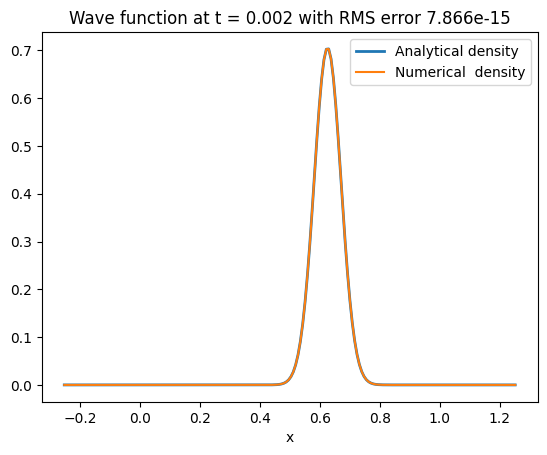

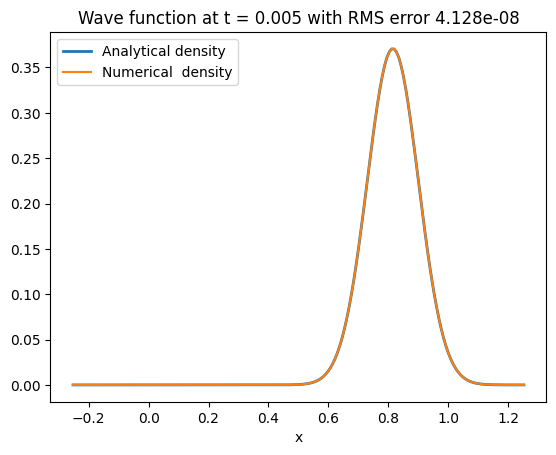

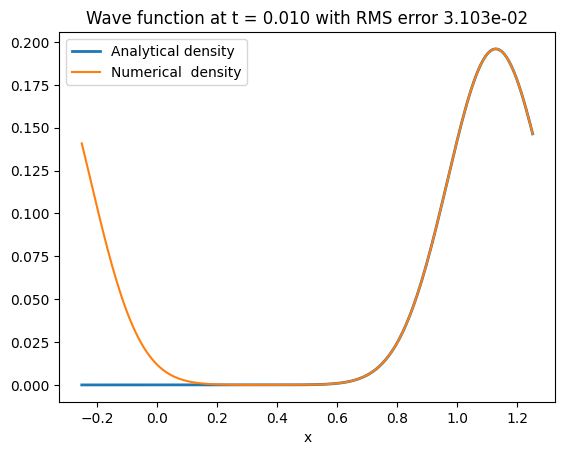

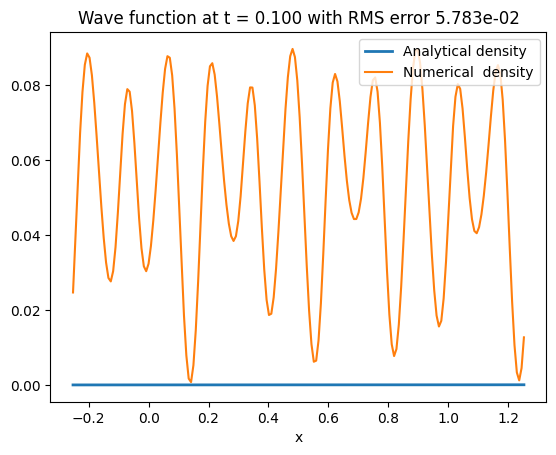

In [3]:
L     = 1                                               # size of physical domain
N_abs = 32                                              # number of points in tot boundary 
N     = 128                                             # number of points in physical domain 
dx    = L/(N - 1)
x     = np.arange(-N_abs, N + N_abs) * dx
x0    = x[0]
x1    = x[-1]
N_tot = len(x) 
L_tot = N_tot * dx
inner = range(N_abs, N_tot - N_abs)
outer = np.array([range(N_abs), range(N_tot - N_abs, N_tot)]).flatten()
k     = np.fft.ifftshift(2*np.pi / L_tot * np.arange(-N_tot/2, N_tot/2)) # momentum grid
t     = 0.0
dt    = 0.2 * dx**2 
tend  = 0.1


def gaussianWave(x, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi

psi = gaussianWave(x,t)

plt.title("Initial wave function") 
plt.plot(x, np.abs(psi)**2, label="Density")
plt.xlabel("x")
plt.legend()
plt.show() 

dump_times = [0.002, 0.005, 0.01, 0.1]
cur_dump   = 0

while t < tend:
    psihat  = scipy.fft.fft(psi)
    psihat  = np.exp(-1j * dt/2 * k**2) * psihat 
    psi     = scipy.fft.ifft(psihat)
    t += dt

    if t > dump_times[cur_dump]:
        cur_dump += 1
        numdens = np.abs(psi)**2
        anadens = np.abs(gaussianWave(x, t))**2 
        plt.title(f"Wave function at t = {t:3.3f} with RMS error {np.sqrt(np.mean((numdens-anadens)**2)):3.3e}") 
        #plt.plot(x, np.real(psi), label=f"Real  part")
        #plt.plot(x, np.imag(psi), label=f"Imag. part")
        plt.plot(x, anadens, lw=2, label="Analytical density")
        plt.plot(x, numdens, label="Numerical  density")
        plt.xlabel("x")
        plt.legend()
        plt.show() 


## Implement absorber

## Fixed-frequency absorber

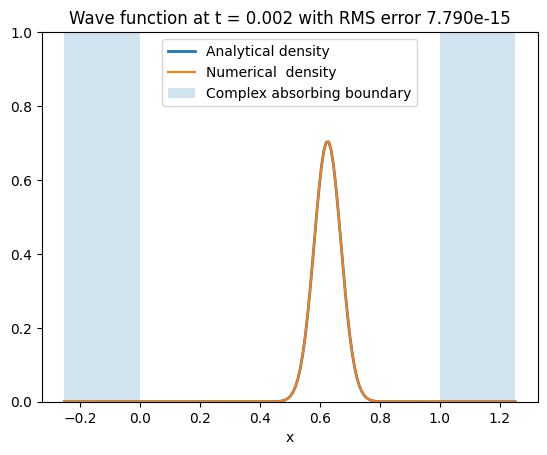

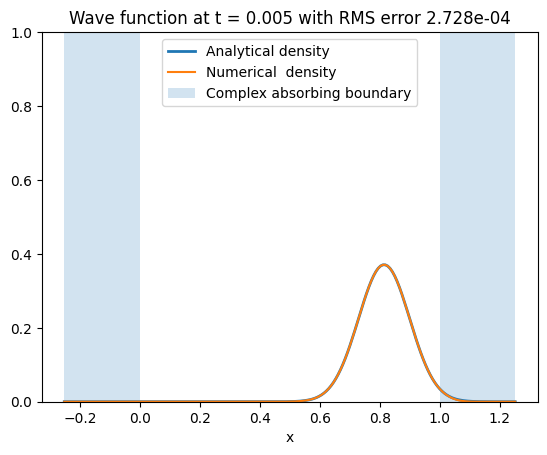

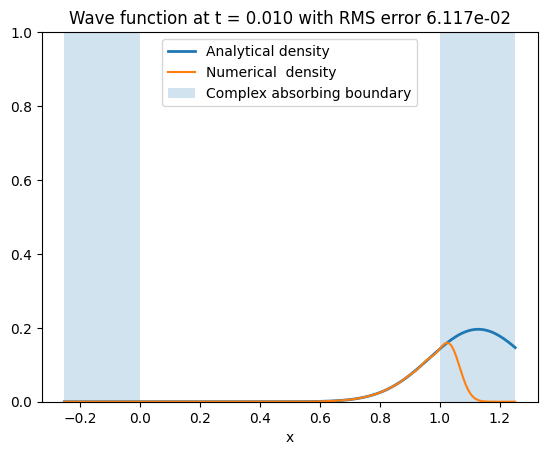

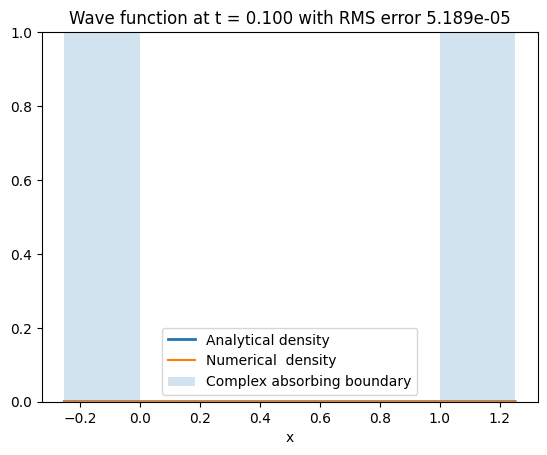

In [4]:

def absorbingPotential(x, L0_phys, L0_buf, L1_phys, L1_buf):
    y = np.zeros(x.shape)

    delta = L1_buf - L1_phys
    
    y[x <= L0_phys] = np.cos( np.pi * (x[x <= L0_phys] - L0_buf) / ( 2 * delta ) )**2
    y[x >= L1_phys] = np.cos( np.pi * (x[x >= L1_phys] - L1_buf) / ( 2 * delta ) )**2
    return y


t          = 0.0
psi        = gaussianWave(x, t) 
dump_times = [0.002, 0.005, 0.01, 0.1]
cur_dump   = 0
tend       = 0.1
m          = 5000
U          = - 1j * m * absorbingPotential(x, 0, x0, L, x1)
while t < tend:

    t += dt

    psi     = psi * np.exp(-1j * U * dt/2)
    psihat  = scipy.fft.fft(psi)
    psihat  = np.exp(-1j * dt/2 * k**2) * psihat 
    psi     = scipy.fft.ifft(psihat)
    psi     = psi * np.exp(-1j * U * dt/2)

    if t > dump_times[cur_dump]:
        cur_dump += 1
        numdens = np.abs(psi)**2
        anadens = np.abs(gaussianWave(x, t))**2 
        plt.title(f"Wave function at t = {t:3.3f} with RMS error {np.sqrt(np.mean((numdens-anadens)**2)):3.3e}") 
        #plt.plot(x, np.real(psi), label=f"Real  part")
        #plt.plot(x, np.imag(psi), label=f"Imag. part")
        plt.plot(x, anadens, lw=2,     label="Analytical density")
        plt.plot(x, numdens,           label="Numerical  density")
        plt.axvspan(x0,  0, alpha=0.2, label="Complex absorbing boundary")
        plt.axvspan(L , x1, alpha=0.2)
        plt.ylim([0, 1])
        plt.xlabel("x")
        plt.legend()
        plt.show() 


## Adaptive frequency absorber

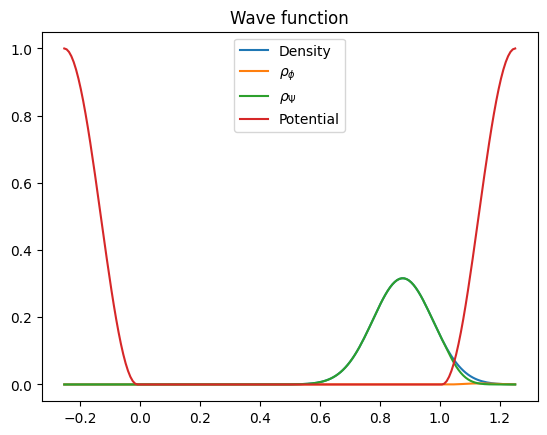

In [5]:


t = 0.006
psi = gaussianWave(x, t) 
V   = absorbingPotential(x, 0 - dx, x0, L + dx, x1)
phi = psi * V 
psi = psi * (1 - V)
plt.title("Wave function") 
plt.plot(x, np.abs(phi + psi)**2, label="Density")
plt.plot(x, np.abs(phi)**2, label=r"$\rho_\phi$")
plt.plot(x, np.abs(psi)**2, label=r"$\rho_\Psi$")
plt.plot(x, V,              label="Potential")
plt.legend()
plt.show()

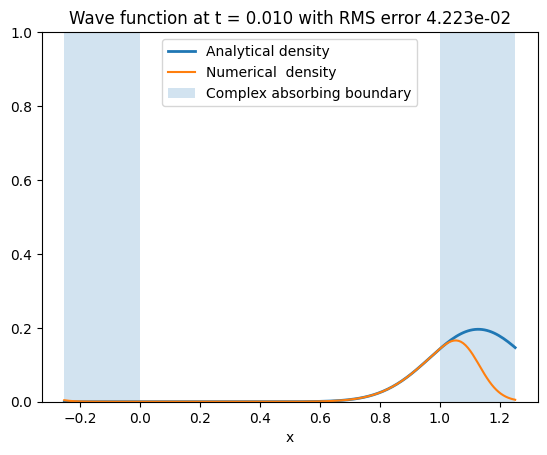

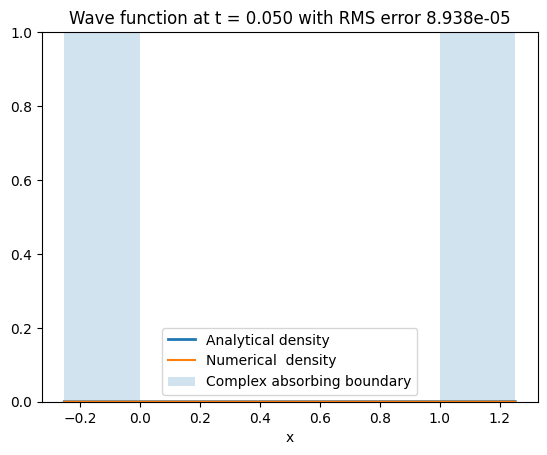

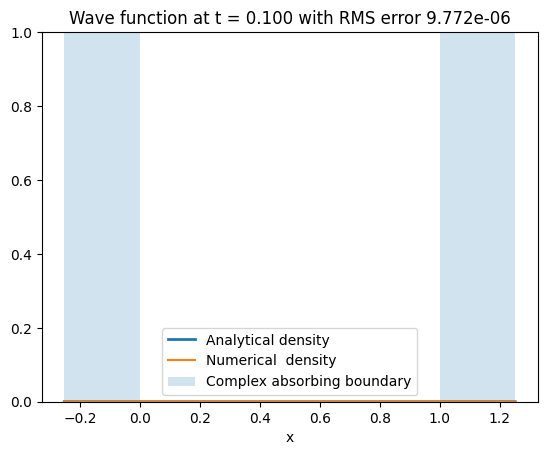

In [7]:

t          = 0.0
psi        = gaussianWave(x, t) 
V          = absorbingPotential(x, 0, x0, L, x1)
L_abs      = 2 * N_abs * dx
k_abs      = np.fft.ifftshift( 2*np.pi / L_abs * np.arange(-N_abs, N_abs) )
dump_times = [0.01, 0.05, 0.1]
cur_dump   = 0
tend       = 0.1
beta       =  13.3
while t < tend:

    t += dt

    #Frequency-dependent absorber
    phi = (psi * V)[outer]
    C   = scipy.fft.fft(phi)
    C   = C * np.exp(-beta * np.abs(k_abs) * dt)
    phi = scipy.fft.ifft(C)
    psi = psi * ( 1 - V )
    psi[outer] = psi[outer] + phi 

    psihat  = scipy.fft.fft(psi)
    psihat  = np.exp(-1j * dt/2 * k**2) * psihat 
    psi     = scipy.fft.ifft(psihat)

    if t > dump_times[cur_dump]:
        cur_dump += 1
        numdens = np.abs(psi)**2
        anadens = np.abs(gaussianWave(x, t))**2 
        plt.title(f"Wave function at t = {t:3.3f} with RMS error {np.sqrt(np.mean((numdens-anadens)**2)):3.3e}") 
        #plt.plot(x, np.real(psi), label=f"Real  part")
        #plt.plot(x, np.imag(psi), label=f"Imag. part")
        plt.plot(x, anadens, lw=2,     label="Analytical density")
        plt.plot(x, numdens,           label="Numerical  density")
        plt.axvspan(x0,  0, alpha=0.2, label="Complex absorbing boundary")
        plt.axvspan(L , x1, alpha=0.2)
        plt.ylim([0, 1])
        plt.xlabel("x")
        plt.legend()
        plt.show()